# ROM example: simply supported plate
This example introduce Reduced Order Model (ROM) technique using simply supported plate vibration.
## 1. Problem statement
- Deflection at the loaded side of the simply supported plate.
- Plate has dimension of length 1000 and width 100 in dimensionless setting.
- Discretized by 1000 quadrilateral elements of size 10.
- Composed with material of $E=3\times10^6$, $\nu=0.28$, and $\rho=8\times10^{-5}$.
- Design parameters are thickness of plate $x_1$, and support position $x_2$.
- The plate excited by impact force.
- DOE of 15 casses: $x_1\in\left\{20, 30, 40\right\}$, and $x_2\in\left\{250,360,500,660,840\right\}$.
><img src="./simply-supported-plate-problem-statement.png" width="50%" height="50%">
><img src="./exciting-force.png" width="50%" height="50%">

## 2. Install requirements
Before getting started, install following requirements using ```pip```:
- numpy
- scipy
- scikit-learn
- matplotlib

In [1]:
!pip install numpy scipy scikit-learn matplotlib

## 3. Load data
Import pre-computed data:
- $\mathbf X$ : Design table of shape $\left(m, n\right)$
- $\mathbf Y$ : Results corresponding design of shape $\left(m, p\right)$
- $\mathbf{XN}$ : New design table of shape $\left(?, n\right)$
- $\mathbf{YN}_\textrm{ref}$ : New results corresponding new design for ground truth of shape $\left(?, p\right)$

In this example, $m=15$, $n=2$, and $p=101$

In [2]:
import numpy as np
# Import pre-computed data
X = np.loadtxt('./data/design_table.csv', delimiter=',')
XN = np.loadtxt('./data/new_design_table.csv', delimiter=',')
Y = np.loadtxt('./data/results.csv', delimiter=',')
YNref = np.loadtxt('./data/new_results_reference.csv', delimiter=',')
t = np.linspace(0, 1, 101)
# Normalization
Xmin, Xmax = X.min(0), X.max(0)
X0 = 2*(X - Xmin)/(Xmax - Xmin) - 1
X0N = 2*(XN - Xmin)/(Xmax - Xmin) - 1
Ymin, Ymax = Y.min(), Y.max()
Y0 = 2*(Y - Ymin)/(Ymax - Ymin) - 1

## 4. Decomposition
Principal Component Anaysis (PCA) of result matrix using Singular Value Decomposition (SVD)
$$\mathbf Y\left(\mathbf y, t\right) = \mathbf G\left(\mathbf y\right)\cdot\mathbf s\cdot\mathbf H\left(t\right)$$
where $\mathbf G$ is a "spatial" operator (matrix) of shape $(m,m)$, $\mathbf s$ is a transfer matrix of shape $(m,m)$, and $\mathbf H$ is a modal operator (matrix) of shape $(m,p)$.

In [105]:
from scipy.linalg import svd
# Decomposition
G, s, H = svd(Y0, full_matrices=False)

## 5. Reduction
The matrix $\mathbf s$ contains singular values of $\mathbf Y$ on its diagonal elements in descending order. The singular values represent the significance of the corresponding mode. In order to reduce dimensionality of $\mathbf Y$, only subsets of $\mathbf G$ and $\mathbf H$ corresponding to higher singular values will be used, i.e.:
$$\mathbf Y\left(\mathbf y, t\right) \approx \mathbf G_r\left(\mathbf y\right)\cdot\mathbf s_r\cdot\mathbf H_r\left(t\right).$$
where $\mathbf G_r$, $\mathbf s_r$, and $\mathbf H_r$ are the subsets of $\mathbf G$, $\mathbf s$, and $\mathbf H$ of shape $(m,r)$, $(r,r)$, and $(r,p)$, respectively.

Number of modes (more than 99% of significance): r = 7


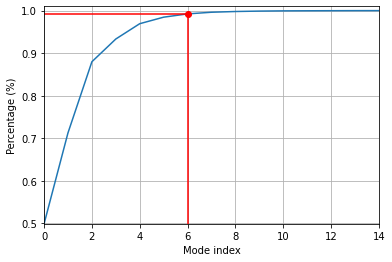

In [111]:
import matplotlib.pyplot as plt
sv_ratio = np.cumsum(s)/np.sum(s)
r = np.where(sv_ratio > 0.99)[0][0]
Gr = G[:, :r]
Sr = np.diag(s[:r])
Hr = H[:r]
print('Number of modes (more than 99% of significance): r =', r+1)

plt.plot(sv_ratio)
plt.plot([r, r], [sv_ratio.min(), sv_ratio[r]], 'r')
plt.plot([0, r], [sv_ratio[r], sv_ratio[r]], 'r')
plt.plot(r, sv_ratio[r], 'ro')
plt.xlim(0, 14)
plt.ylim(sv_ratio.min(), 1.01)
plt.ylabel('Percentage (%)')
plt.xlabel('Mode index')
plt.grid()
plt.show()

## 6. Reconstruction
In the reconstruction step, a regression model is built for the reduced spatial operator $\mathbf G_r$, instead of the response $\mathbf Y$ itself. Any methods can be used for regression, and Gaussian Process Regressor is used in this example. Finally, the new results $\mathbf{YN}$ is reconstructed by 
$$\mathbf{YN} = \mathbf G_r'\left(\mathbf y\right)\cdot\mathbf s_r\cdot\mathbf H_r\left(t\right).$$

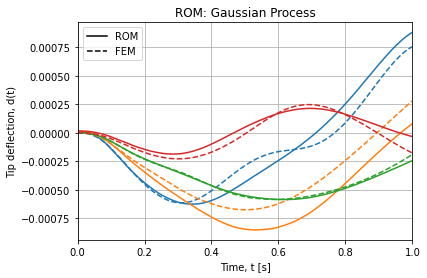

In [102]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
kernel = RBF()
gpr = GaussianProcessRegressor(
    kernel=kernel, random_state=0, n_restarts_optimizer=10
).fit(X0, Gr)
GrN = gpr.predict(X0N)
Y0N = GrN @ Sr @ Hr
YN = (Y0N + 1)*(Ymax - Ymin)/2 + Ymin

for i, (yN, zN) in enumerate(zip(YN, YNref)):
    plt.plot(t, yN, c='C%d'%i)
    plt.plot(t, zN, '--', c='C%d'%i)
plt.plot([], [], 'k-', label='ROM')
plt.plot([], [], 'k--', label='FEM')
plt.title('ROM: Gaussian Process')
plt.xlabel('Time, t [s]')
plt.ylabel('Tip deflection, d(t)')
plt.xlim([0, 1])
plt.legend()
plt.grid()
plt.show()